# 20250402 - parse result of COMSOL parametric sweep
* Specifically emerging from simulation of photobleached species in a circular region in contact with bath from which recovery emerges.
* The COMSOL model file is `/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/2025_3D_nosurfbinding.mph`.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style('ticks')

import numpy as np
import scipy

In [2]:
fname='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250402_sweepKbleach_.csv'
chimney = pd.read_csv(fname)
chimney=chimney[['kbleach (1/s)', 'Time (s)', 'U (mol/m^3)']]
chimney

,kbleach (1/s),Time (s),U (mol/m^3)
0,0.0001,0.0,3.000000e-03
1,0.0001,50.0,2.990400e-03
2,0.0001,100.0,2.984500e-03
3,0.0001,150.0,2.979800e-03
4,0.0001,200.0,2.976600e-03
...,...,...,...
2608,100.0000,9800.0,9.800900e-08
2609,100.0000,9850.0,9.790900e-08
2610,100.0000,9900.0,9.781000e-08
2611,100.0000,9950.0,9.771200e-08


In [3]:
chimney.head()

,kbleach (1/s),Time (s),U (mol/m^3)
0,0.0001,0.0,0.003000
1,0.0001,50.0,0.002990
2,0.0001,100.0,0.002985
3,0.0001,150.0,0.002980
4,0.0001,200.0,0.002977


In [4]:
kbleachList=chimney['kbleach (1/s)'].unique()

In [5]:
len(kbleachList)

13

In [7]:
sns.color_palette('mako', as_cmap=True)(0.5)

(0.20692679, 0.48201774, 0.63812656, 1.0)

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

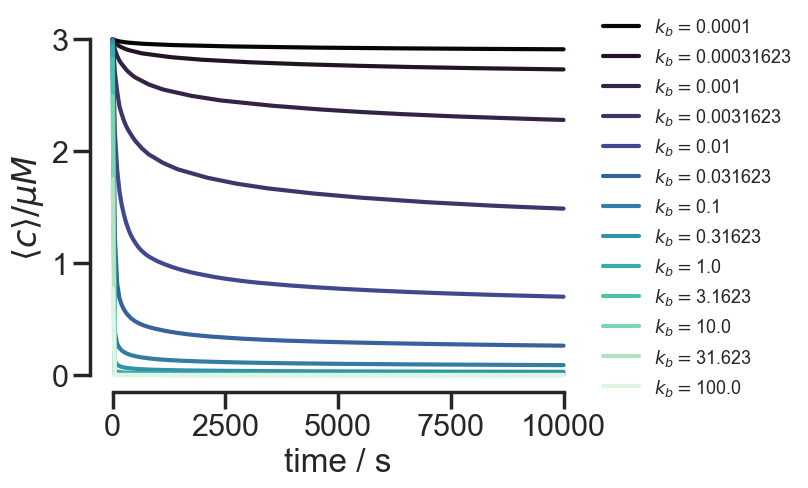

In [10]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

In [11]:
chimney_subset['Time (s)'].values[-1]

10000.0

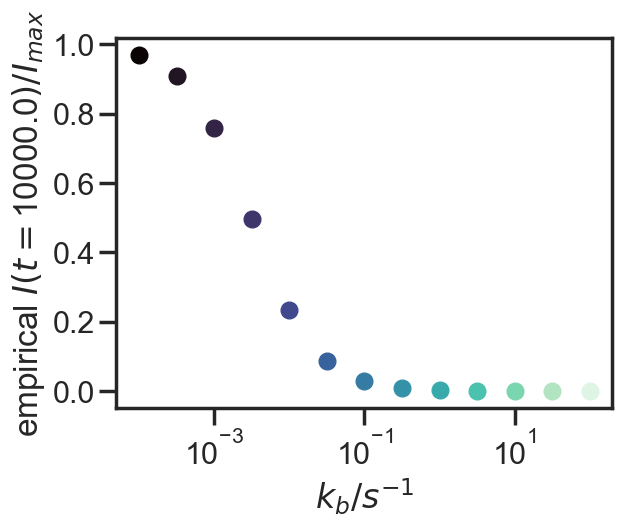

In [12]:
for ii in range(len(kbleachList)):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleachList[ii]]
    plt.plot(kbleachList[ii], chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].values.max(), 'o', color=colorList[ii])
plt.ylabel("empirical $I(t=$"+str(chimney_subset['Time (s)'].values[-1])+'$)/I_{max}$')
plt.xlabel('$k_b / s^{-1}$')
plt.xscale('log')

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

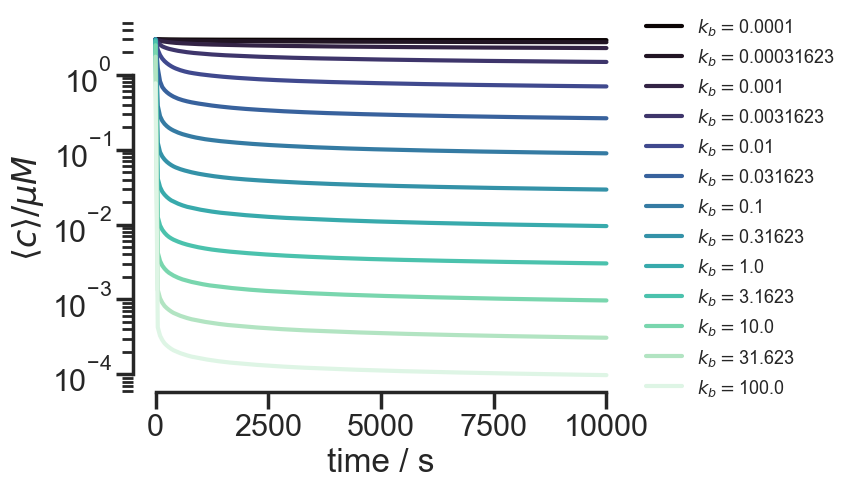

In [13]:

colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

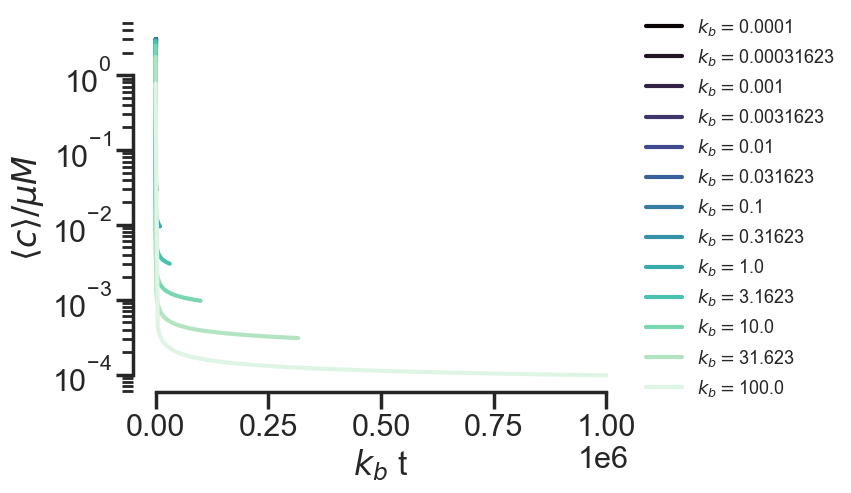

In [14]:
### Try simplest data collapse,
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)']*kbleach, 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('$k_b$ t')
plt.ylabel(r'$\langle c \rangle / \mu M$')

# we be plottin

In [166]:
tol=1e-8
#--------------------------------------------------------------------#
def singExpConst_max1(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [ tau1, Iinf], where tau1 is the decay constant of the exponential and Iinf is the limit of the intensity as you go to infinity
    """
    tau1 = p0[0]
    Iinf = p0[1]

    return (1-Iinf)*np.exp(-times/tau1)+Iinf
    
def singExpConstFit_max1(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExpConst_max1(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def doubExp_max1(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [tau1, w2, tau2], where tau1(2) is the decay constant of the first(second) exponential and Iinf is the limit of the intensity as you go to infinity
    """
    tau1 = p0[0]
    Iinf = p0[1]
    tau2 = p0[2]

    return (1-Iinf)*np.exp(-times/tau1)+Iinf*np.exp(-times/tau2)
    
def doubExpFit_max1(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp_max1(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

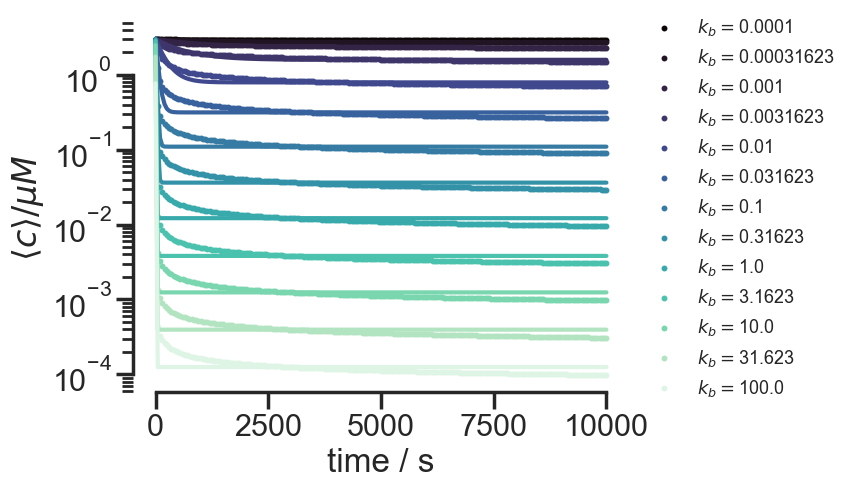

In [16]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max()))
    
    plt.plot(chimney_subset['Time (s)'], 
             singExpConst_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

In [17]:
chimney_subset['Time (s)'].head(81)

2412       0.0
2413      50.0
2414     100.0
2415     150.0
2416     200.0
         ...  
2488    3800.0
2489    3850.0
2490    3900.0
2491    3950.0
2492    4000.0
Name: Time (s), Length: 81, dtype: float64

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

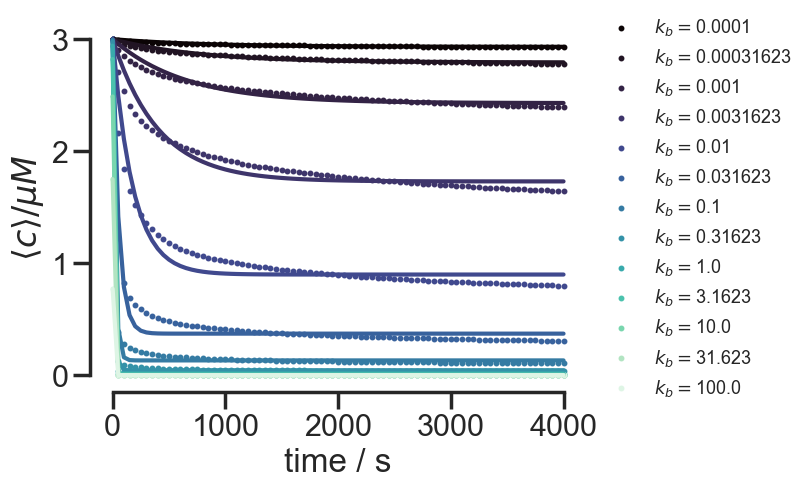

In [18]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'][:81], 
             10**3*chimney_subset['U (mol/m^3)'][:81], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'][:81], 
                                    chimney_subset['U (mol/m^3)'][:81]/chimney_subset['U (mol/m^3)'][:81].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'][:81].values[-1]/chimney_subset['U (mol/m^3)'][:81].max()))
    
    plt.plot(chimney_subset['Time (s)'][:81], 
             singExpConst_max1(chimney_subset['Time (s)'][:81],temp_fit.x)*chimney_subset['U (mol/m^3)'][:81].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

      fun: 0.0005630534676843565
 hess_inv: array([[ 5.96456362e+08, -1.60717609e+03],
       [-1.60717609e+03,  7.60819923e-03]])
      jac: array([ 3.78349796e-10, -9.04172339e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 330
      nit: 39
     njev: 106
   status: 2
  success: False
        x: array([1.52027328e+03, 9.71825524e-01])
      fun: 0.005112452440529113
 hess_inv: array([[ 1.98195692e+02, -1.89972886e-03],
       [-1.89972886e-03,  2.73518606e-03]])
      jac: array([-5.82076609e-11,  5.76494494e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 257
      nit: 22
     njev: 82
   status: 2
  success: False
        x: array([1.41563426e+03, 9.16146221e-01])
      fun: 0.03873255696044571
 hess_inv: array([[1.25305694e+02, 3.47938167e-02],
       [3.47938167e-02, 2.99639402e-03]])
      jac: array([4.65661287e-10, 2.38604844e-06])
  message: 'Desired error not necessarily achieved due to 

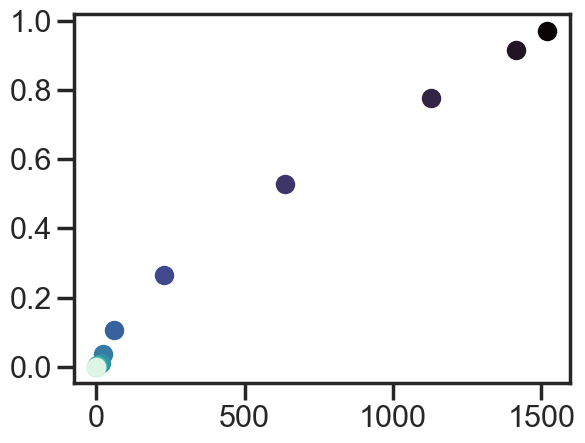

In [19]:
for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, 0.75))
    print(temp_fit)
    plt.scatter(temp_fit.x[0], temp_fit.x[1], color = colorList[ii])

      fun: 0.012783718884894992
 hess_inv: array([[4.10081932e+10, 1.53833534e+07, 7.31881289e+09],
       [1.53833534e+07, 5.83865109e+03, 2.74549736e+06],
       [7.31881289e+09, 2.74549736e+06, 1.30620293e+09]])
      jac: array([ 2.18860805e-08, -3.26900044e-05, -1.01281330e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 648
      nit: 82
     njev: 159
   status: 2
  success: False
        x: array([1.05928275e+05, 5.95992283e+00, 1.17120504e+05])
      fun: 0.0008229596765481613
 hess_inv: array([[4.61950221e+03, 1.72321467e-01, 8.39299514e+03],
       [1.72321467e-01, 1.97653999e-03, 3.11679330e-01],
       [8.39299514e+03, 3.11679330e-01, 1.52626452e+04]])
      jac: array([1.45519152e-10, 2.57228385e-06, 2.40106601e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 843
      nit: 78
     njev: 206
   status: 2
  success: False
        x: array([6.13663932e+02, 9.40863205e-01, 2.73125094e+05])


Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

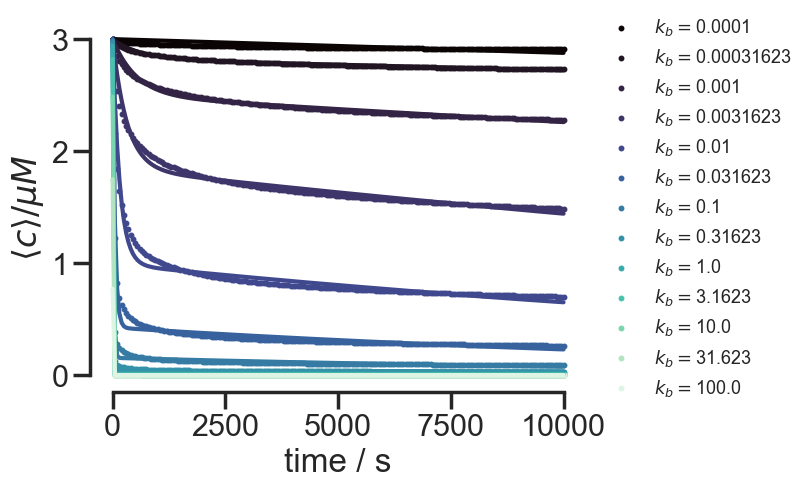

In [20]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    print(temp_fit)
    
    plt.plot(chimney_subset['Time (s)'], 
             doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')



      fun: 0.012783718884894992
 hess_inv: array([[4.10081932e+10, 1.53833534e+07, 7.31881289e+09],
       [1.53833534e+07, 5.83865109e+03, 2.74549736e+06],
       [7.31881289e+09, 2.74549736e+06, 1.30620293e+09]])
      jac: array([ 2.18860805e-08, -3.26900044e-05, -1.01281330e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 648
      nit: 82
     njev: 159
   status: 2
  success: False
        x: array([1.05928275e+05, 5.95992283e+00, 1.17120504e+05])
      fun: 0.0008229596765481613
 hess_inv: array([[4.61950221e+03, 1.72321467e-01, 8.39299514e+03],
       [1.72321467e-01, 1.97653999e-03, 3.11679330e-01],
       [8.39299514e+03, 3.11679330e-01, 1.52626452e+04]])
      jac: array([1.45519152e-10, 2.57228385e-06, 2.40106601e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 843
      nit: 78
     njev: 206
   status: 2
  success: False
        x: array([6.13663932e+02, 9.40863205e-01, 2.73125094e+05])


Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

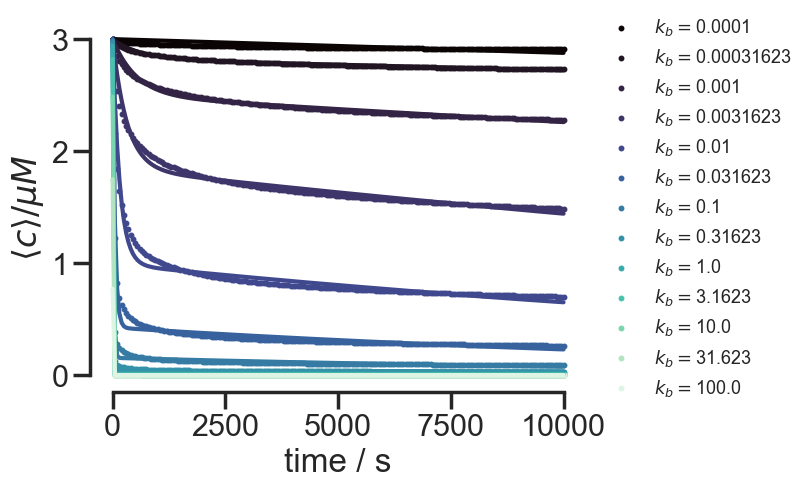

In [26]:
#### start here

colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    print(temp_fit)
    
    plt.plot(chimney_subset['Time (s)'], 
             doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')



      fun: 0.012783718884894992
 hess_inv: array([[4.10081932e+10, 1.53833534e+07, 7.31881289e+09],
       [1.53833534e+07, 5.83865109e+03, 2.74549736e+06],
       [7.31881289e+09, 2.74549736e+06, 1.30620293e+09]])
      jac: array([ 2.18860805e-08, -3.26900044e-05, -1.01281330e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 648
      nit: 82
     njev: 159
   status: 2
  success: False
        x: array([1.05928275e+05, 5.95992283e+00, 1.17120504e+05])
      fun: 0.0008229596765481613
 hess_inv: array([[4.61950221e+03, 1.72321467e-01, 8.39299514e+03],
       [1.72321467e-01, 1.97653999e-03, 3.11679330e-01],
       [8.39299514e+03, 3.11679330e-01, 1.52626452e+04]])
      jac: array([1.45519152e-10, 2.57228385e-06, 2.40106601e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 843
      nit: 78
     njev: 206
   status: 2
  success: False
        x: array([6.13663932e+02, 9.40863205e-01, 2.73125094e+05])


No handles with labels found to put in legend.


      fun: 0.02552355133072811
 hess_inv: array([[ 3.51599121e+00,  1.30021572e-03, -2.28390625e+02],
       [ 1.30021572e-03,  8.87566128e-03, -1.32625642e+03],
       [-2.28390625e+02, -1.32625642e+03,  4.74379327e+08]])
      jac: array([6.98491931e-10, 6.56815246e-07, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 552
      nit: 61
     njev: 135
   status: 2
  success: False
        x: array([5.01410045e+01, 1.41925271e-01, 1.62024249e+04])
      fun: 0.0053381336763369935
 hess_inv: array([[ 7.15339743e+03,  1.02659331e+00, -3.80418569e+06],
       [ 1.02659331e+00,  2.77161960e-03,  2.95846451e+02],
       [-3.80418569e+06,  2.95846451e+02,  4.54762378e+09]])
      jac: array([ 1.33877620e-09, -4.29828651e-06,  1.16415322e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 508
      nit: 63
     njev: 124
   status: 2
  success: False
        x: array([2.07093621e+01, 5.15132241e-02, 

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

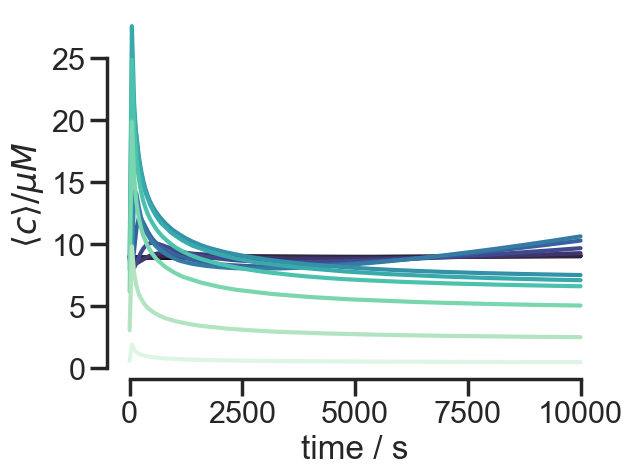

In [27]:
####### plot multiplicative residual

#### start here

colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    print(temp_fit)
    
    plt.plot(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)']/doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')



(-100.0, 2500.0)

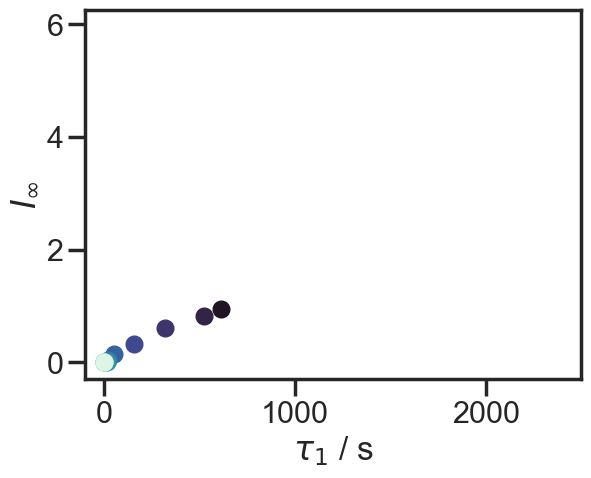

In [22]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(temp_fit.x[0], temp_fit.x[1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel(r'$\tau_1$ / s')
plt.ylabel(r'$I_\infty$')

plt.xlim([-100, 2500])

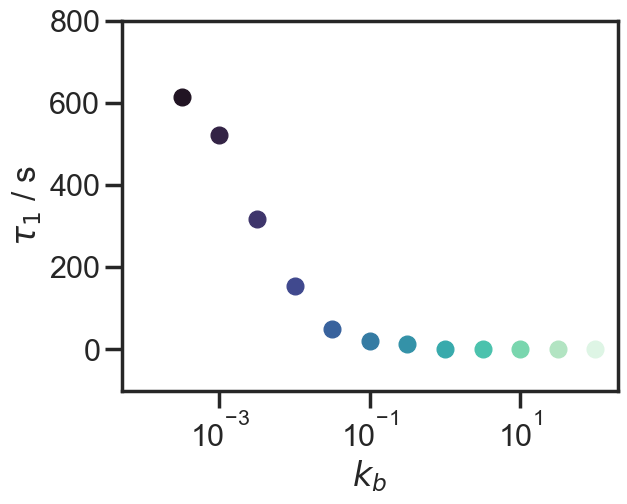

In [23]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[0], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$\tau_1$ / s')
plt.xlabel(r'$k_b$')

plt.ylim(-100, 800)

plt.xscale('log')

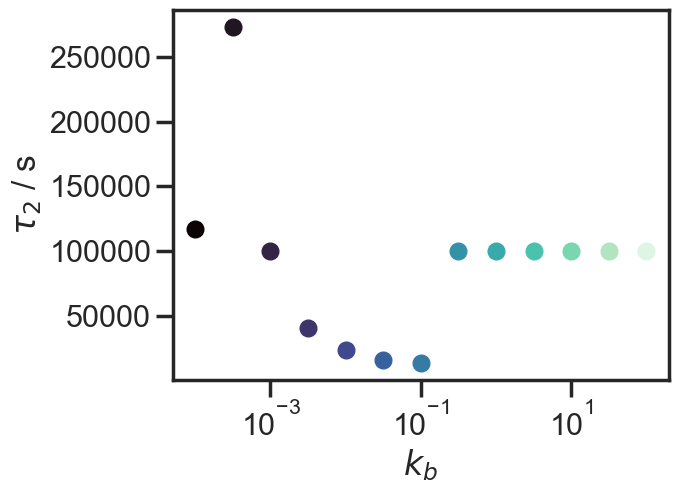

In [24]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[-1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$\tau_2$ / s')
plt.xlabel(r'$k_b$')

plt.xscale('log')

# plt.ylim(-100, 800)

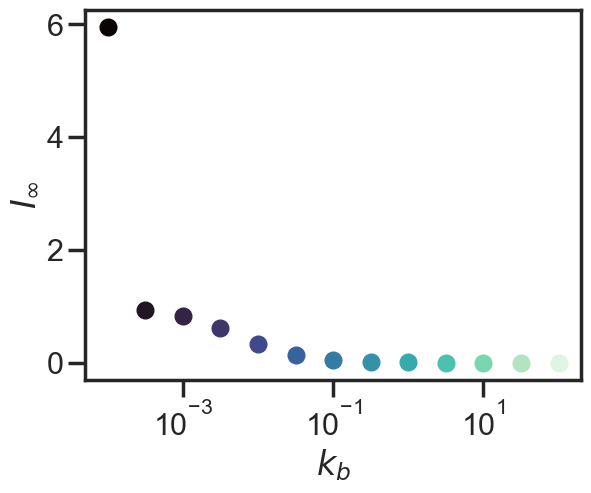

In [25]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$I_\infty$')
plt.xlabel(r'$k_b$')

plt.xscale('log')

# plt.ylim(-100, 800)

## `20250416` - plot CDF of Poisson

In [8]:
import math

In [19]:
def poissonDistPMF(l, k):
    return l**k * np.exp(-l)/math.factorial(k)

def poissonDistCDFcomplement(l, k):
    return 1-np.sum([poissonDistPMF(l, j) for j in range(0,k+1)])

In [20]:
poissonDistCDFcomplement(1, 4)

np.float64(0.00365984682734366)

In [21]:
aVals=np.array([0, 1, 5, 25, 5**3, 5**4, 5**5, 5**6])
l=200; # photons per probe per (20s) pulse

plt.plot(aVals, [poissonDistCDFcomplement(l, a) for a in aVals], 'm-')

OverflowError: int too large to convert to float

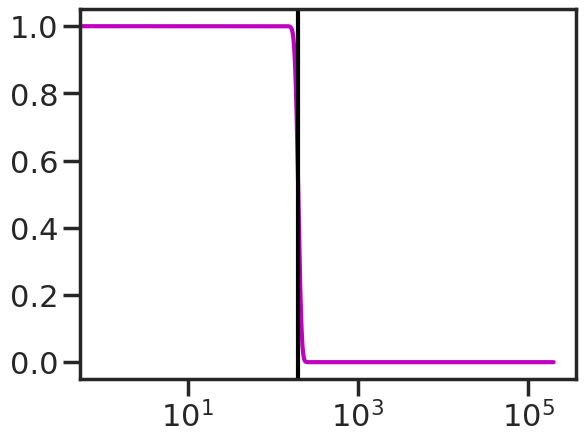

In [35]:
aVals=np.arange(0, 2*10**5, 1)
## succumb to the hegemony of scipy

plt.plot(aVals, 1-scipy.stats.poisson.cdf(aVals, l), 'm-')
plt.xscale('log')
plt.axvline(x=200, color='k')

In [37]:
1-scipy.stats.poisson.cdf(10**5, 200)

np.float64(0.0)

# needs no date - Still in the same notebook to placate Gabriel. 

# 20250416 - Parameter sweep in $k_b$ and $D$ in comsol :o

In [297]:
#yes, ana is meAN
#aname = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg.csv'
#aname = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg_take2.csv'
aname1 = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg_um2persUnits.csv'
aname2 = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg_um2persUnits_kb0.01-1.csv'
aname3 = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg_um2persUnits_D4000.csv'
anames = [aname1, aname2, aname3]

raw2dSweep=pd.concat([pd.read_csv(aname, header=4) for aname in anames])
raw2dSweep['kbleach (1/s)']=raw2dSweep['% kbleach (1/s)']
raw2dSweep['u (uM)'] = raw2dSweep['Dependent variable u (mol/m^3)']*10**3 #convert mol/m^3 to uM
raw2dSweep=raw2dSweep[['kbleach (1/s)', 'D (um^2/s)', 'Time (s)', 'u (uM)']]
raw2dSweep['conditionTuple_kb_D']=raw2dSweep.apply(lambda row: (row['kbleach (1/s)'], row['D (um^2/s)']), axis=1)
raw2dSweep

,kbleach (1/s),D (um^2/s),Time (s),u (uM),conditionTuple_kb_D
0,0.001,4.0,0,2.999941,"(0.001, 4.0)"
1,0.001,4.0,50,2.869872,"(0.001, 4.0)"
2,0.001,4.0,100,2.757655,"(0.001, 4.0)"
3,0.001,4.0,150,2.655982,"(0.001, 4.0)"
4,0.001,4.0,200,2.579850,"(0.001, 4.0)"
...,...,...,...,...,...
1000,10.000,4000.0,9800,0.003875,"(10.0, 4000.000000000001)"
1001,10.000,4000.0,9850,0.003815,"(10.0, 4000.000000000001)"
1002,10.000,4000.0,9900,0.003756,"(10.0, 4000.000000000001)"
1003,10.000,4000.0,9950,0.003698,"(10.0, 4000.000000000001)"


In [298]:
grouped=raw2dSweep.groupby('conditionTuple_kb_D').apply(lambda row: (row['Time (s)'].values, row['u (uM)'].values))
grouped

conditionTuple_kb_D
(0.001, 4.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 40.0)                 ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 400.0)                ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 4000.000000000001)    ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 4.0)                   ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 40.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 400.0)                 ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 4000.000000000001)     ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 4.0)                    ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 40.0)                   ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 400.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 4000.000000000001)      ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(1.0, 4.0)          

In [299]:
sortTupleByFirstEntries = lambda pair: (pair[0][np.argsort(pair[0])], pair[-1][np.argsort(pair[0])])

In [300]:
def sortTupleByFirstEntries(pair):
    return (pair[0][np.argsort(pair[0])], 
            pair[-1][np.argsort(pair[0])])

In [301]:
# unit test
#sortTupleByFirstEntries((np.array([2,1,3,4]), np.array([3,2,1,4])))

In [302]:
grouped=grouped.apply(sortTupleByFirstEntries)
grouped

conditionTuple_kb_D
(0.001, 4.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 40.0)                 ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 400.0)                ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 4000.000000000001)    ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 4.0)                   ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 40.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 400.0)                 ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 4000.000000000001)     ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 4.0)                    ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 40.0)                   ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 400.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 4000.000000000001)      ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(1.0, 4.0)          

In [303]:
raw2dSweep['conditionTuple_kb_D']

0                    (0.001, 4.0)
1                    (0.001, 4.0)
2                    (0.001, 4.0)
3                    (0.001, 4.0)
4                    (0.001, 4.0)
                  ...            
1000    (10.0, 4000.000000000001)
1001    (10.0, 4000.000000000001)
1002    (10.0, 4000.000000000001)
1003    (10.0, 4000.000000000001)
1004    (10.0, 4000.000000000001)
Name: conditionTuple_kb_D, Length: 4020, dtype: object

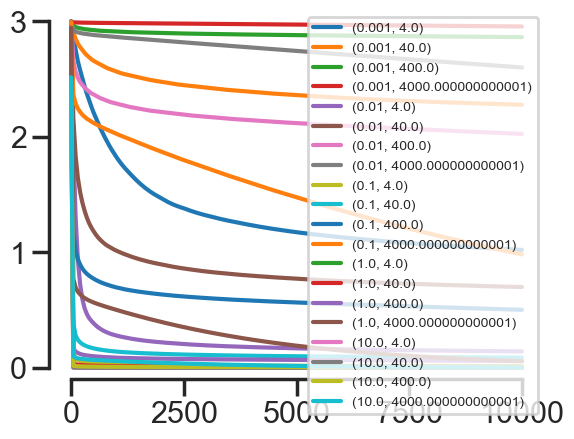

In [304]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
for opt in np.unique(raw2dSweep['conditionTuple_kb_D']):
    ax.plot(grouped[opt][0], grouped[opt][1], label=str(opt))
#ax.plot(*grouped[(0.01, 40.0)], 'b-', label='0.01')

ax.set_ylim([-0.1, 3.1])
plt.legend(fontsize=10)
sns.despine(trim=True)

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

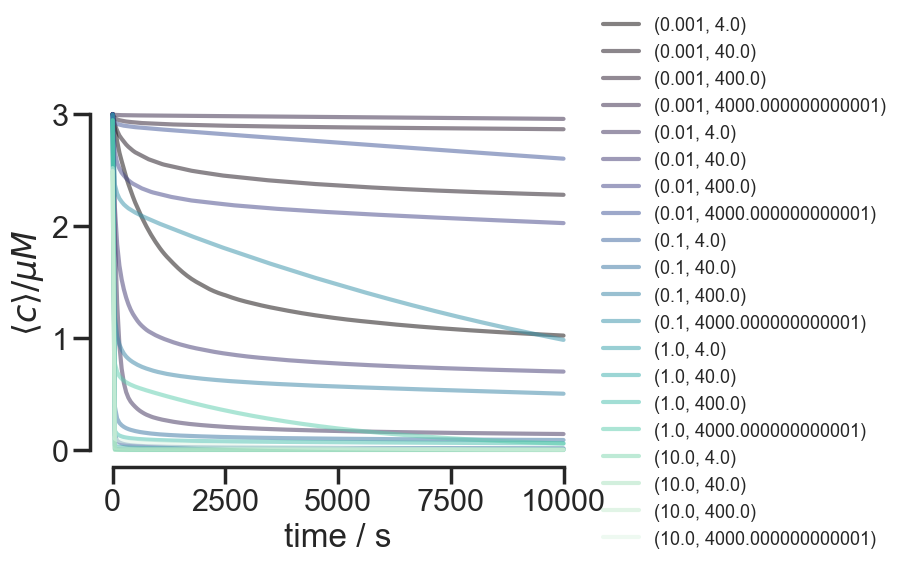

In [305]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(np.unique(raw2dSweep['conditionTuple_kb_D'])))]

for ii, opt in enumerate(np.unique(raw2dSweep['conditionTuple_kb_D'])):
    plt.plot(grouped[opt][0], 
             grouped[opt][1], color=colorList[ii],
             alpha=0.5,
            label=str(opt))

sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

# Plot all the comsol curves and their fits organized by D and kb

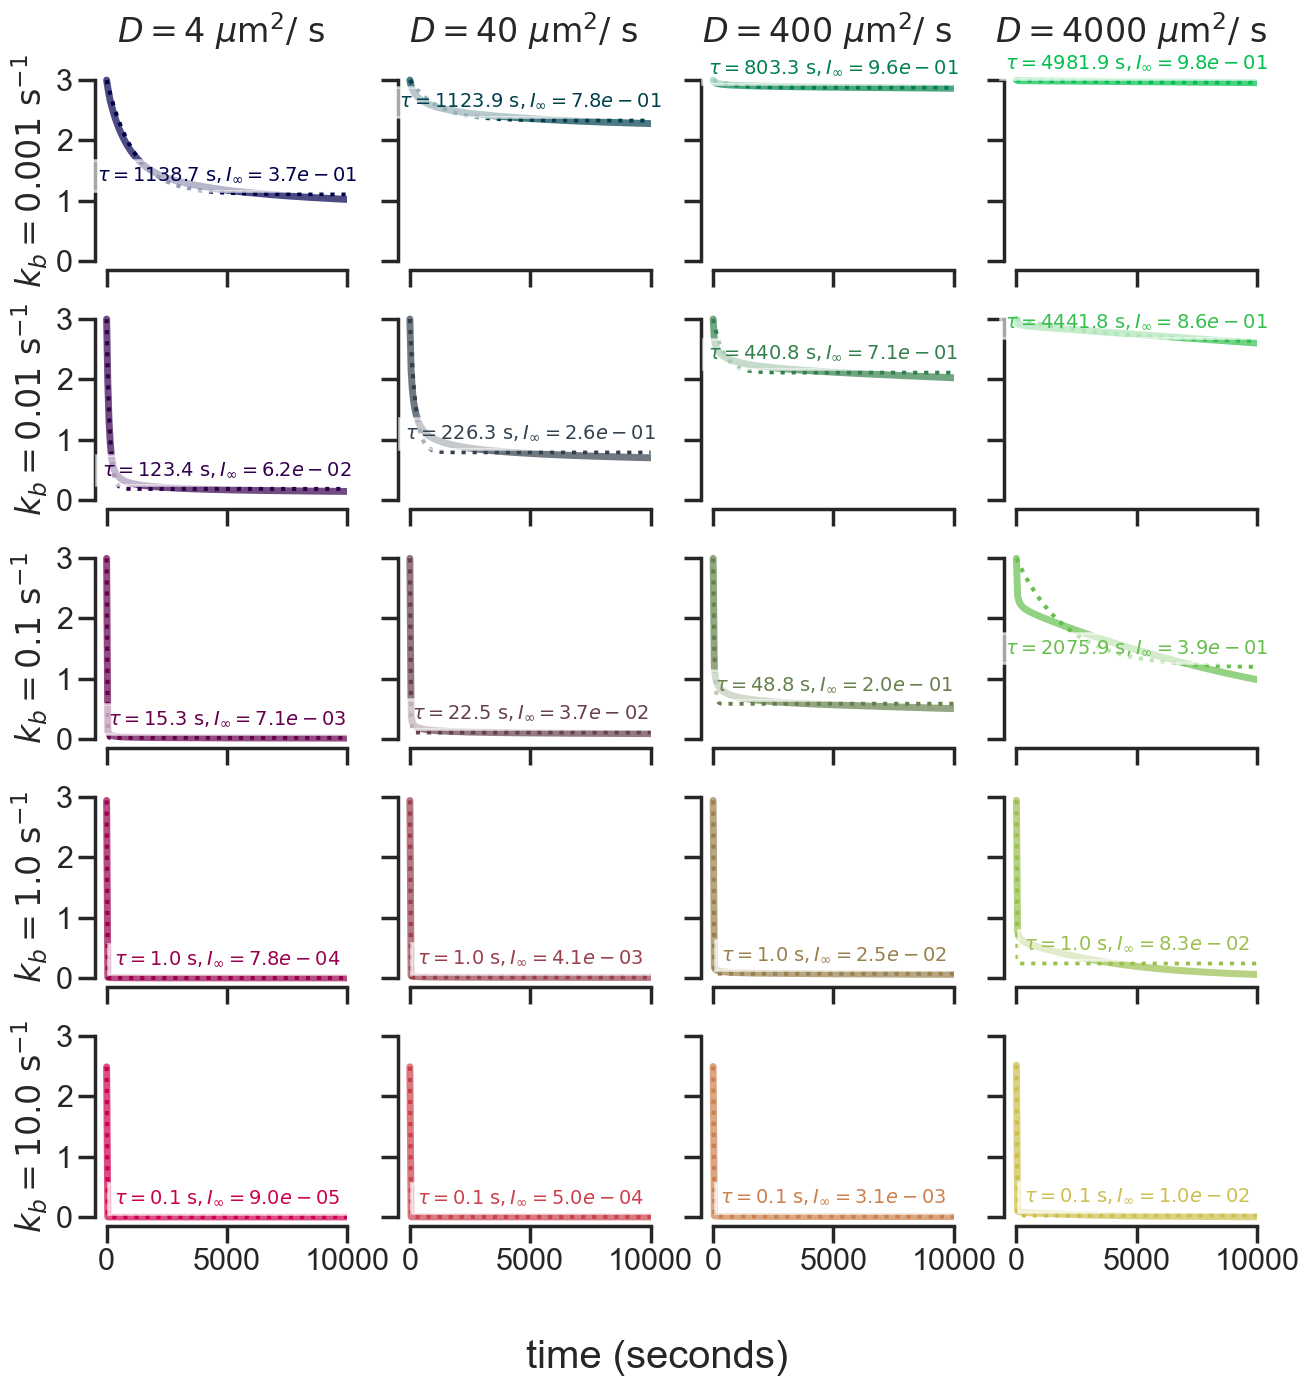

In [487]:
#x axis limits
istart = 0
tstop = grouped[(uniquekbvals[ii], uniqueDvals[j])][0].max()
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])

#unique parameter sweep values
uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])

#instantiate figure
fig, axs=plt.subplots(len(uniquekbvals), len(uniqueDvals), figsize=(15,15), sharex=True, sharey=True)

#loop through parameters
for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        
        #plot the comsol data
        axs[ii,j].plot(*grouped[(uniquekbvals[ii], uniqueDvals[j])], 
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 0.7), 
                       ls='-', lw=5
                       )
        
        # plot fit too - set fit to x axis limits
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[ii,j].plot(grouped[(uniquekbvals[ii], uniqueDvals[j])][0], 
             singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(), ':', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        # label fit results in plot
        fitString=r'$\tau ='+str(round(temp_fit.x[0], 1))+'~\mathrm{s}, I_\infty = '+'{:.1e}'.format(round(temp_fit.x[-1],5))+'$'
        axs[ii,j].text(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop][(istart+istop)//2],#[-90],
                       (singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max())[-1]+0.15,
                       fitString,
                      ha='center',
                      va='bottom',
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 1),
                      fontsize=14,
                      bbox=dict(facecolor='white', alpha=0.6))
        
        
        # labels
        axs[0,j].set_title(r'$D = '+str(round(uniqueDvals[j]))+'~\mu \mathrm{m}^2/~\mathrm{s}$', y=1.1)

    axs[ii,0].set_ylabel(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s}^{-1}$')

#configure axis
axs[0][0].set_xlim(-0.05*tstop,tstop)
axs[0][0].set_xticks(np.arange(0, tstop+tstop/2, tstop/2))#, minor=True)
axs[0][0].set_yticks(np.arange(0, 4, 1))
fig.supxlabel('time (seconds)')
#stylish
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250417_SmMultDvskbSingExpConst.pdf", bbox_inches='tight', transparent=True)

## Crop fit to 4000 seconds

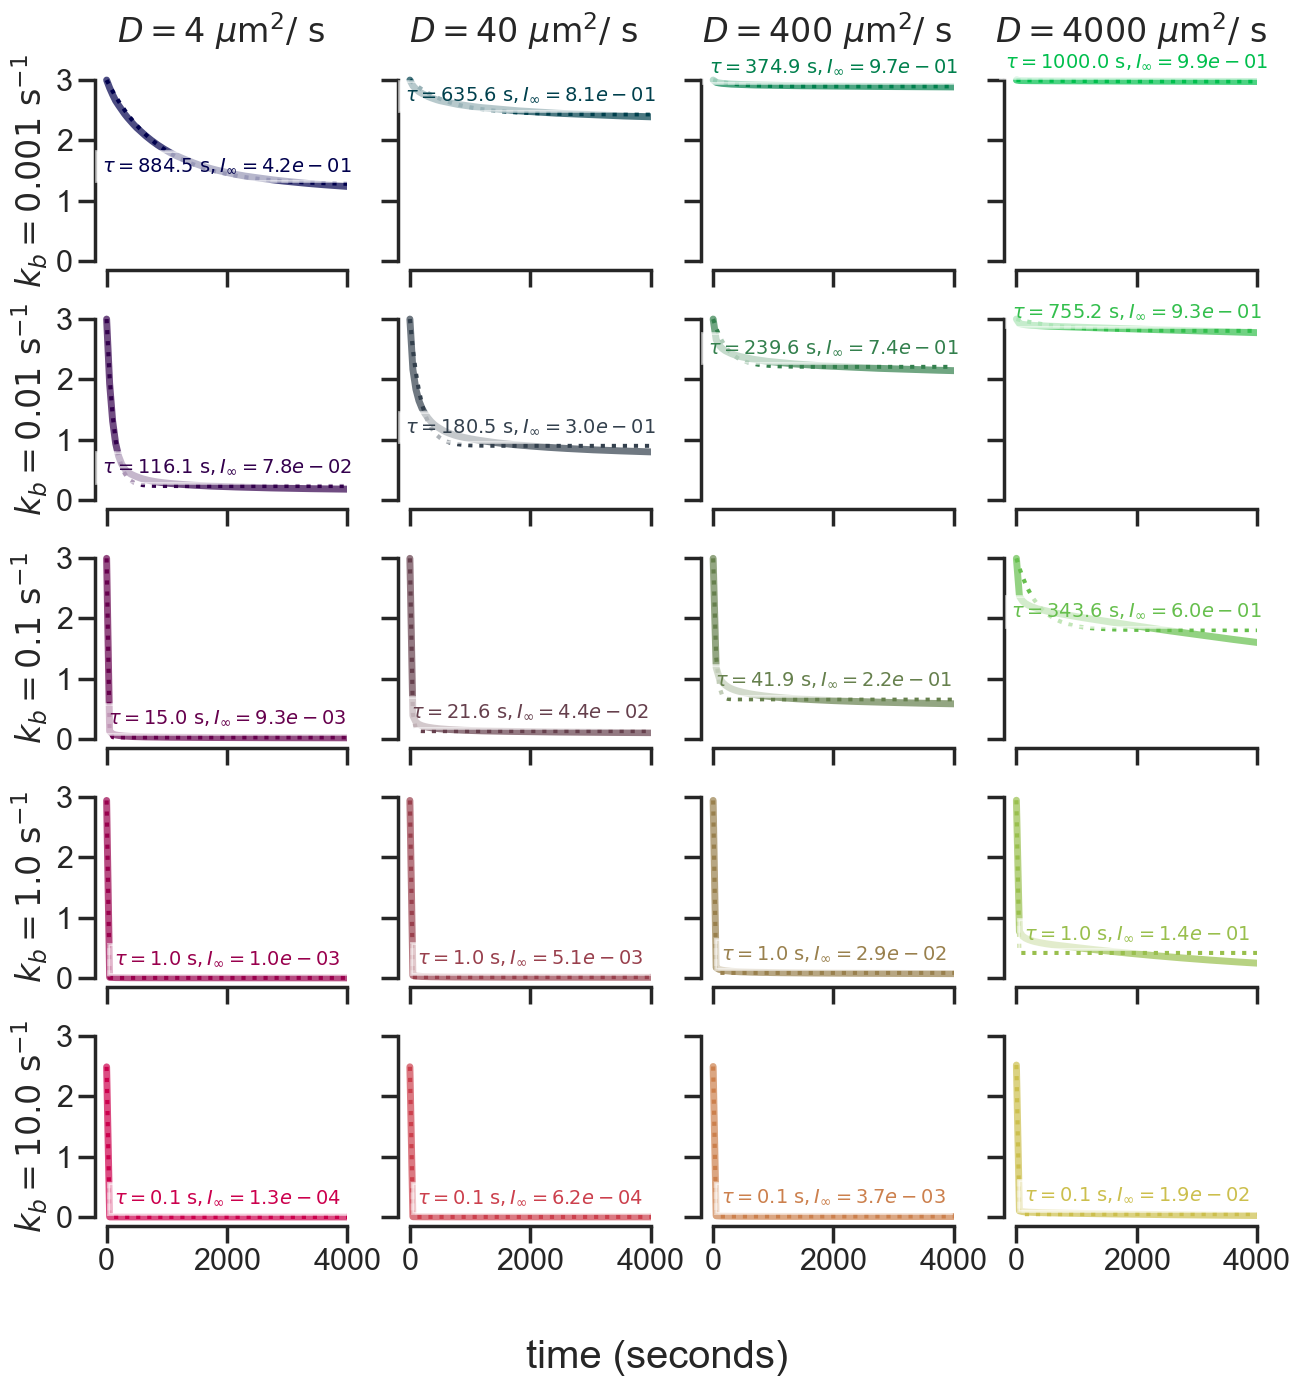

In [488]:
#x axis limits
istart = 0
tstop = 4000
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])

#unique parameter sweep values
uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])

#instantiate figure
fig, axs=plt.subplots(len(uniquekbvals), len(uniqueDvals), figsize=(15,15), sharex=True, sharey=True)

#loop through parameters
for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        
        #plot the comsol data
        axs[ii,j].plot(*grouped[(uniquekbvals[ii], uniqueDvals[j])], 
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 0.7), 
                       ls='-', lw=5
                       )
        
        # plot fit too - set fit to x axis limits
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[ii,j].plot(grouped[(uniquekbvals[ii], uniqueDvals[j])][0], 
             singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(), ':', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        # label fit results in plot
        fitString=r'$\tau ='+str(round(temp_fit.x[0], 1))+'~\mathrm{s}, I_\infty = '+'{:.1e}'.format(round(temp_fit.x[-1],5))+'$'
        axs[ii,j].text(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop][(istart+istop)//2],#[-90],
                       (singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max())[-1]+0.15,
                       fitString,
                      ha='center',
                      va='bottom',
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 1),
                      fontsize=14,
                      bbox=dict(facecolor='white', alpha=0.6))
        
        
        # labels
        axs[0,j].set_title(r'$D = '+str(round(uniqueDvals[j]))+'~\mu \mathrm{m}^2/~\mathrm{s}$', y=1.1)

    axs[ii,0].set_ylabel(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s}^{-1}$')

    
#configure axis
axs[0][0].set_xlim(-0.05*tstop,tstop)
axs[0][0].set_xticks(np.arange(0, tstop+tstop/2, tstop/2))#, minor=True)
axs[0][0].set_yticks(np.arange(0, 4, 1))
fig.supxlabel('time (seconds)')
#stylish
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250417_SmMultDvskbSingExpConst4000sfit.pdf", bbox_inches='tight', transparent=True)

## Show change in kb for each D

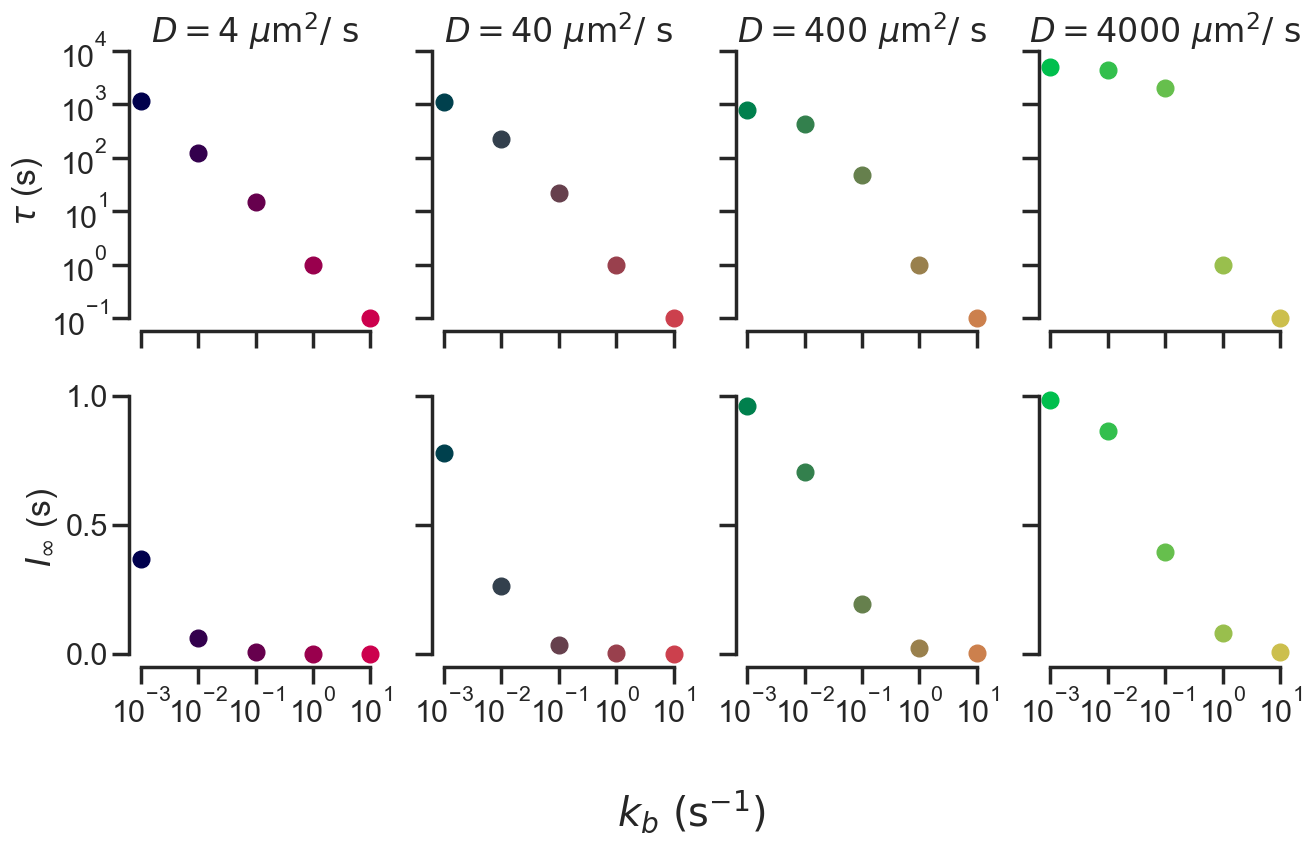

In [489]:
#x axis limits
istart = 0
tstop = grouped[(uniquekbvals[ii], uniqueDvals[j])][0].max()
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])


## PLOT fit parameter values!

uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])


fig, axs=plt.subplots(2, len(uniqueDvals), figsize=(15,8), sharex=True, sharey='row')

for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        

        # plot fit too
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[0][j].plot(uniquekbvals[ii], temp_fit.x[0],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        axs[1][j].plot(uniquekbvals[ii], temp_fit.x[1],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        
        # labels
        axs[0][j].set_title(r'$D = '+str(round(uniqueDvals[j]))+'~\mu \mathrm{m}^2/~\mathrm{s}$')

        axs[0][j].set_yscale('log')
        # axs[1][j].set_yscale('log')
        axs[0][j].set_xscale('log')
        axs[1][j].set_xscale('log')
fig.supxlabel(r'$k_b~(\mathrm{s}^{-1})$', y=-0.1)
axs[0][0].set_ylabel(r'$\tau$ (s)')
axs[1][0].set_ylabel(r'$I_\infty$ (s)')
axs[0][0].set_xticks(np.logspace(np.log10(uniquekbvals.min()), np.log10(uniquekbvals.max()), len(uniquekbvals)))#, minor=True)
axs[0][0].set_yticks(np.logspace(-1, 4, 6))#, minor=True)

#axs[0][0].set_yticks(np.arange(0, 4, 1))
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250417_FitParamsSingExpConstconstDvarykb10000sfit.pdf", bbox_inches='tight', transparent=True)

## Show change in D for each kb

Text(0.5, 1.0, '$I_\\infty$')

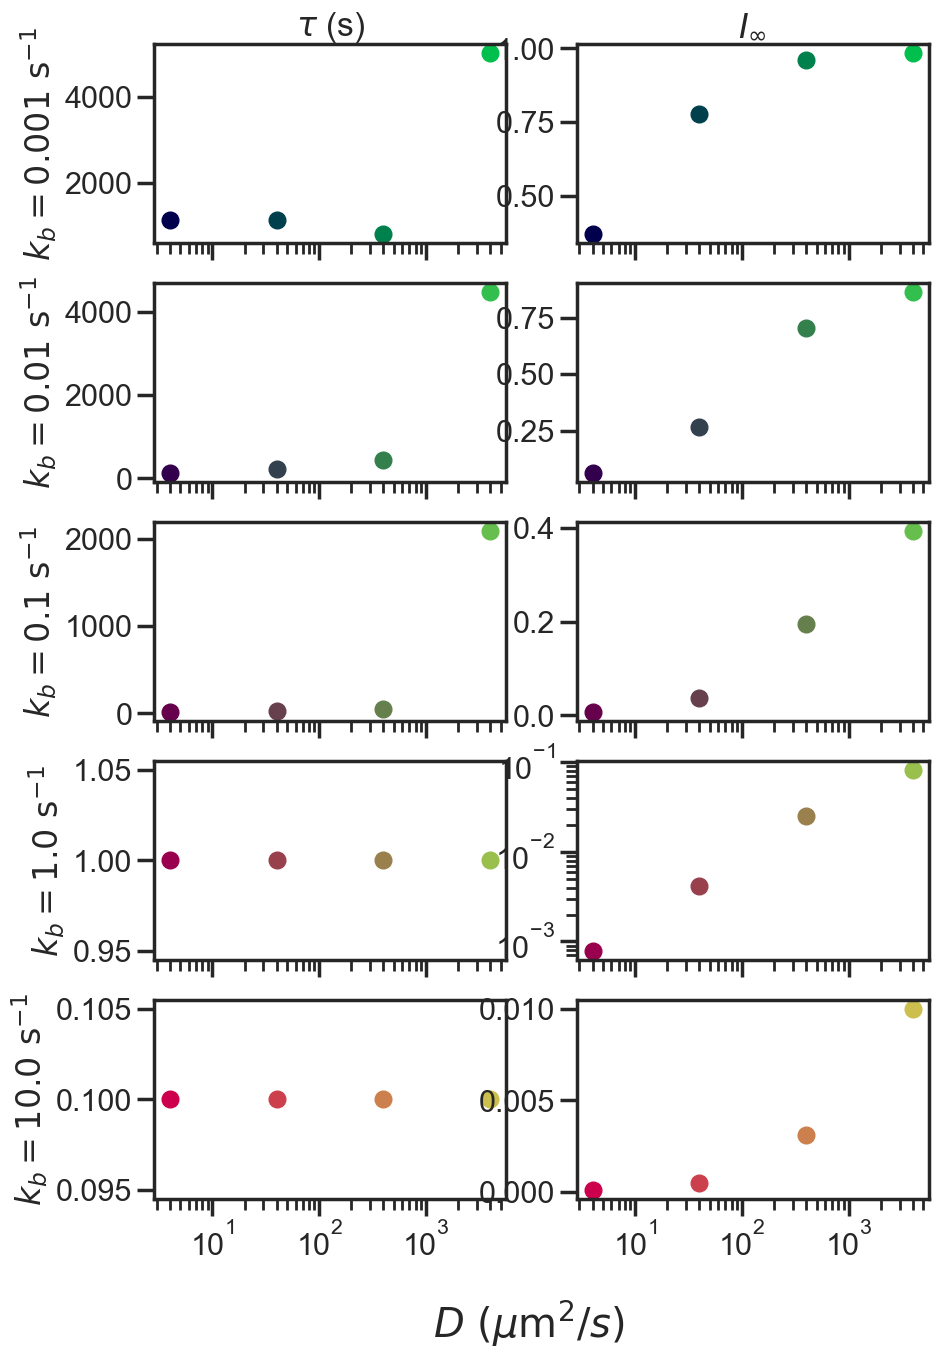

In [322]:
## PLOT fit parameter values!

uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])


fig, axs=plt.subplots(len(uniquekbvals), 2, figsize=(10,15), sharex=True, )#sharey=True)

for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        

        # plot fit too
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[ii][0].plot(uniqueDvals[j], temp_fit.x[0],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        axs[ii][1].plot(uniqueDvals[j], temp_fit.x[1],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        # # label fit results in plot
        # fitString=r'$\tau ='+str(round(temp_fit.x[0], 5))+', I_\infty = '+str(round(temp_fit.x[-1],5))+'$'
        # axs[ii,j].text(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][-90],
        #                (singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max())[-1]+0.15,
        #                fitString,
        #               ha='center',
        #               va='bottom',
        #               color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 1),
        #               fontsize=14,
        #               bbox=dict(facecolor='white', alpha=0.6))
        
        
        # labels
        #axs[j].set_title(r'$D = '+str(uniqueDvals[j])+'~\mu \mathrm{m}^2/~\mathrm{s}$')
        
    axs[ii][0].set_ylabel(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s}^{-1}$')
        
axs[j][1].set_yscale('log')
axs[j][1].set_xscale('log')
fig.supxlabel(r'$D ~ (\mu \mathrm{m}^2/s)$')
axs[0][0].set_title(r'$\tau$ (s)')
axs[0][1].set_title(r'$I_\infty$')
#sns.despine(trim=True)



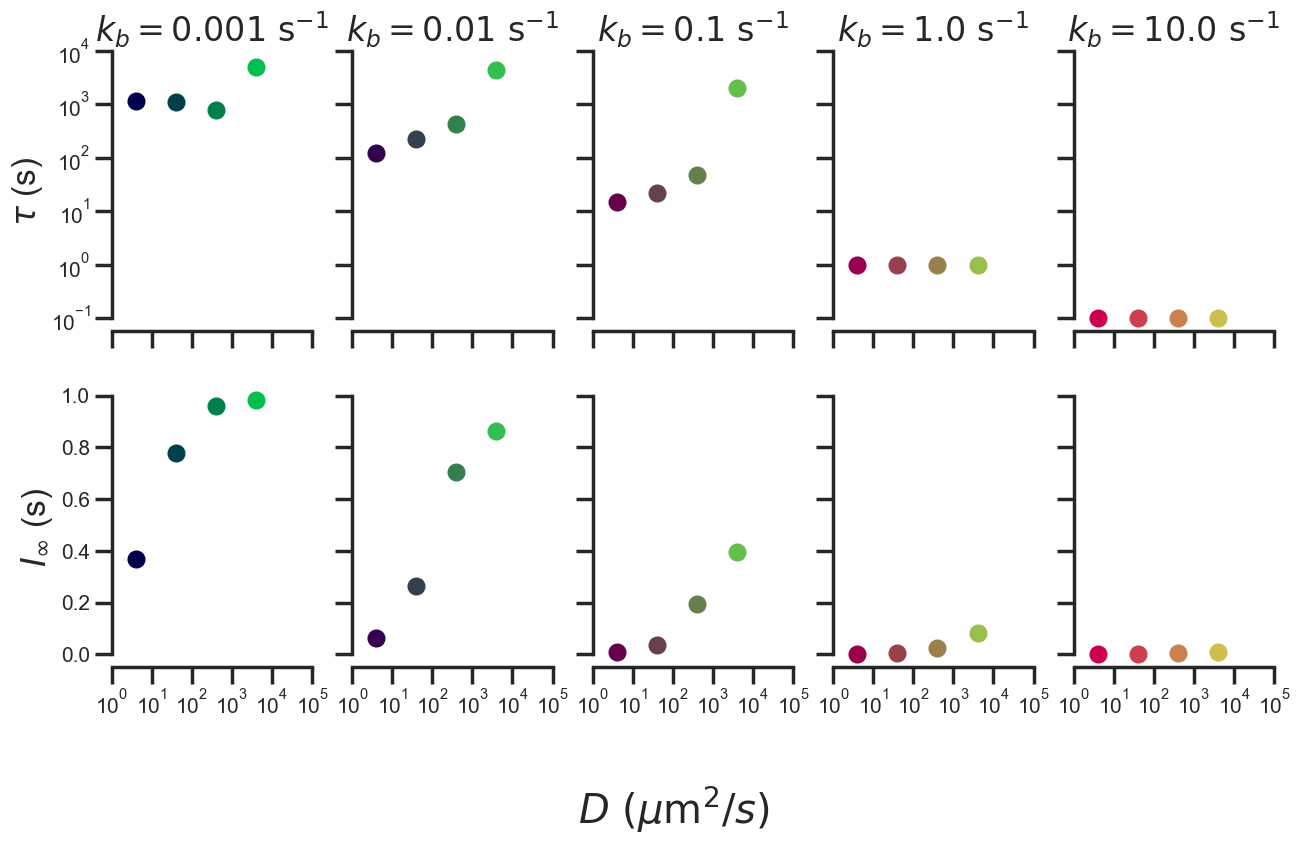

In [490]:
#x axis limits
istart = 0
tstop = grouped[(uniquekbvals[ii], uniqueDvals[j])][0].max()
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])


## PLOT fit parameter values!

uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])


fig, axs=plt.subplots(2, len(uniquekbvals), figsize=(15,8), sharex=True, sharey='row')

for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        

        # plot fit too
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[0][ii].plot(uniqueDvals[j], temp_fit.x[0],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        axs[1][ii].plot(uniqueDvals[j], temp_fit.x[1],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        
        # labels
        axs[0][ii].set_title(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s^{-1}}$')
        axs[0][ii].tick_params(labelsize=15)
        axs[1][ii].tick_params(labelsize=15)

axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
fig.supxlabel(r'$D ~ (\mu \mathrm{m}^2/s)$', y=-0.1)
axs[0][0].set_ylabel(r'$\tau$ (s)')
axs[1][0].set_ylabel(r'$I_\infty$ (s)')
axs[0][0].set_xticks(np.logspace(0, 5, 6))#, minor=True)
#axs[0][0].set_xticks(np.logspace(np.log10(4), np.log10(4000), 4))#, minor=True)
axs[0][0].set_yticks(np.logspace(-1, 4, 6))#, minor=True)

#axs[0][0].set_yticks(np.arange(0, 4, 1))
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250417_FitParamsSingExpConstconstkbvaryD10000sfit.pdf", bbox_inches='tight', transparent=True)

## Fit to a double exponential

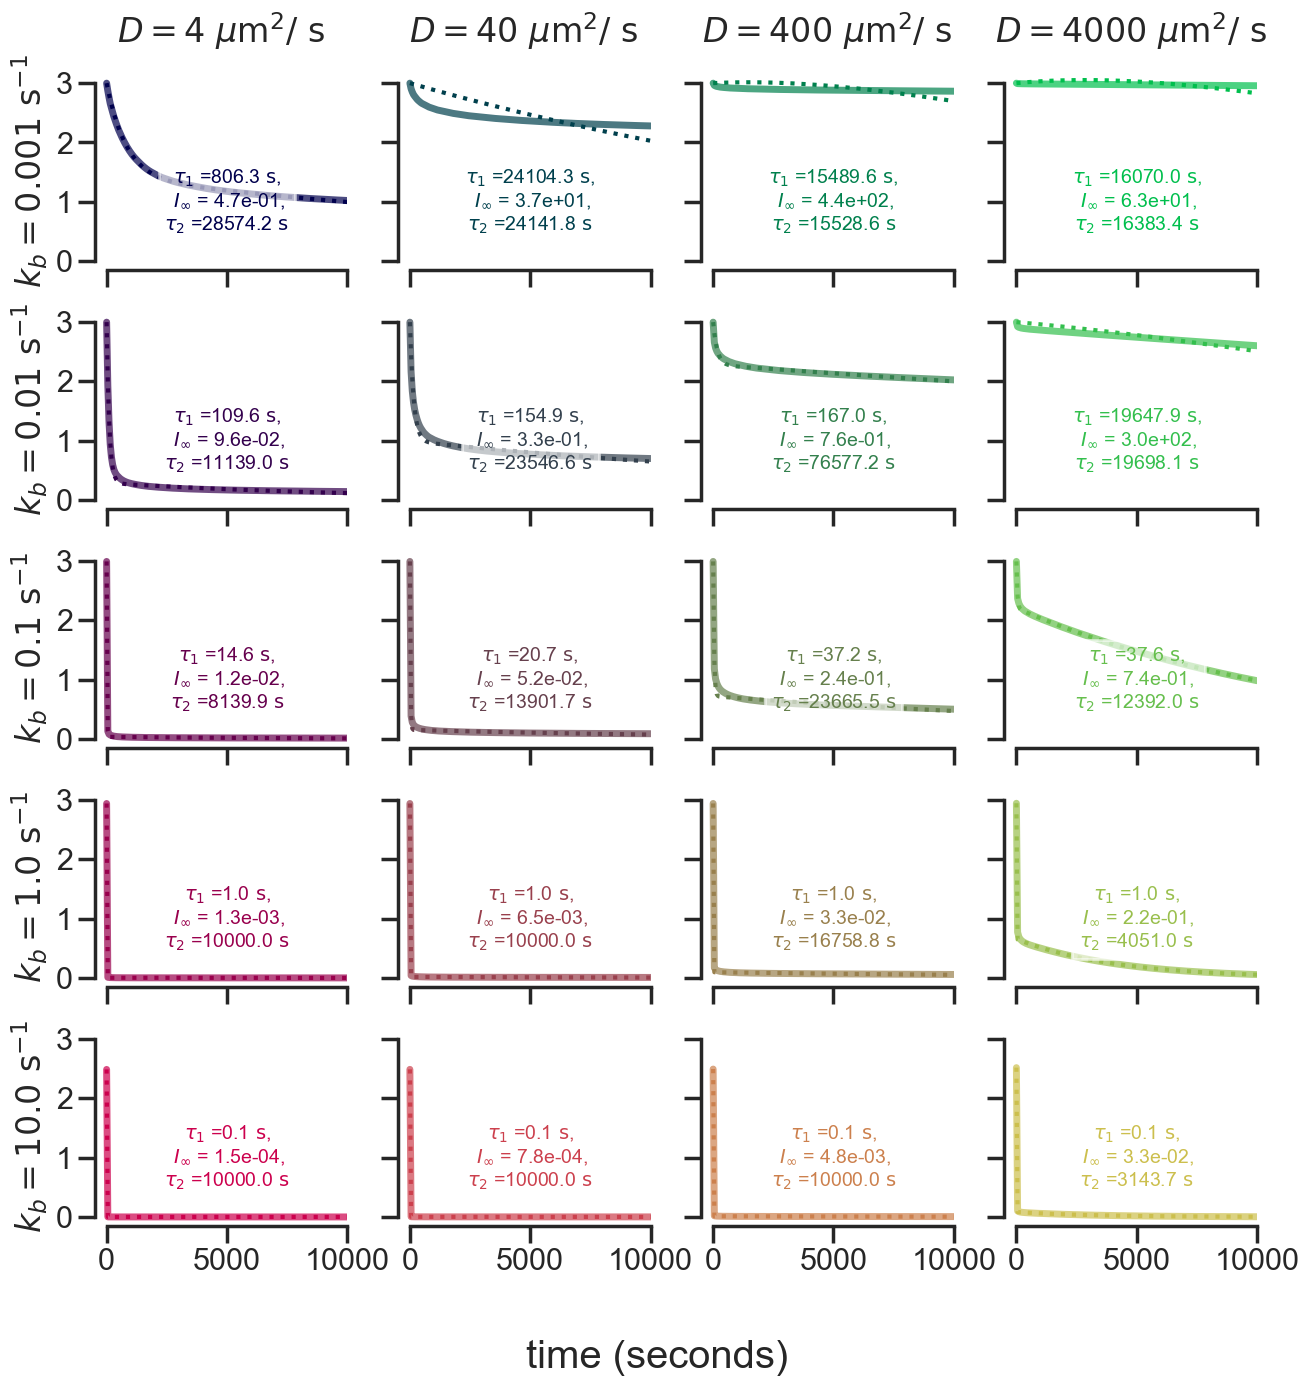

In [493]:
#x axis limits
istart = 0
tstop = grouped[(uniquekbvals[ii], uniqueDvals[j])][0].max()
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])

#unique parameter sweep values
uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])

#instantiate figure
fig, axs=plt.subplots(len(uniquekbvals), len(uniqueDvals), figsize=(15,15), sharex=True, sharey=True)

#loop through parameters
for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        
        #plot the comsol data
        axs[ii,j].plot(*grouped[(uniquekbvals[ii], uniqueDvals[j])], 
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 0.7), 
                       ls='-', lw=5
                       )
        
        # plot fit too - set fit to x axis limits
        temp_fit = doubExpFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop].max(),
                                        (1/uniquekbvals[ii], 0.75, 10000))
        axs[ii,j].plot(grouped[(uniquekbvals[ii], uniqueDvals[j])][0], 
             doubExp_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(), ':', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        # label fit results in plot
        fitString=r'$\tau_1$ ='+str(round(temp_fit.x[0], 1))+'$~\mathrm{s}$,\n $I_\infty$ = '+'{:.1e}'.format(round(temp_fit.x[1],5))+', \n'+r'$\tau_2$ ='+str(round(temp_fit.x[2], 1))+'$~\mathrm{s}$'
        #fitString='shock size \n $n-n_{fd}$'
        axs[ii,j].text(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop][(istart+istop)//2],#[-90],
                       1,#(singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max())[1]+0.15,
                       fitString,
                      ha='center',
                      va='center',
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 1),
                      fontsize=14,
                      bbox=dict(facecolor='white', alpha=0.6))
        
        
        # labels
        axs[0,j].set_title(r'$D = '+str(round(uniqueDvals[j]))+'~\mu \mathrm{m}^2/~\mathrm{s}$', y=1.1)

    axs[ii,0].set_ylabel(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s}^{-1}$')

#configure axis
axs[0][0].set_xlim(-0.05*tstop,tstop)
axs[0][0].set_xticks(np.arange(0, tstop+tstop/2, tstop/2))#, minor=True)
axs[0][0].set_yticks(np.arange(0, 4, 1))
fig.supxlabel('time (seconds)')
#stylish
sns.despine(trim=True)

(2400.0, 2520.0)

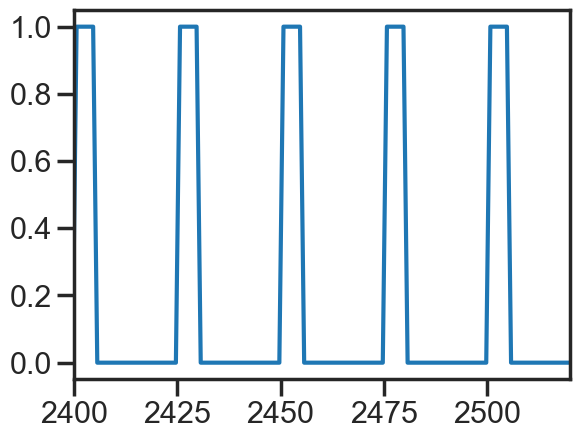

In [507]:
#pulsedir = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250418_pulse150ms.csv'
pulsedir = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250418_pulse5s.csv'
pulsedata = pd.read_csv(pulsedir, header=7)
plt.plot(pulsedata['% t'], pulsedata['an1(t)'])
plt.xlim(2400, 2520)